In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import re
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
import collections
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch._six import string_classes, int_classes

import torchvision
from torchvision import datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.ticker as plticker

import transforms

# Download COCO dataset

Run "get_coco_dataset.sh" to download the training data if you haven't already

In [2]:
#Uncomment to run bash script
#!./data/get_coco_dataset.sh

In [3]:
coco_path = './data/coco.names'
train_target_txt = "./data/coco/trainvalno5k.txt"
valid_target_txt = "./data/coco/5k.txt"

In [4]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [5]:
classes = load_coco(coco_path)

# Draw

In [6]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=0.5))
    draw_outline(patch, 2)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_grid(ax, grid_interval):
    loc = plticker.MultipleLocator(base=grid_interval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

# Transforms

In [7]:
def getTransforms(dim, bbs_idx=np.arange(0,4), box_coord_scale='ratio', isTrain=True):
    if isTrain:
        transform = transforms.Compose([transforms.BasicAugmentations(),
                                        transforms.Letterbox(dim, box_coord_scale=box_coord_scale, bbs_idx=bbs_idx),
                                        transforms.ToTensor(),
                                      ])
    else:
        transform = transforms.Compose([transforms.Letterbox(dim, box_coord_scale=box_coord_scale, bbs_idx=bbs_idx),
                                         transforms.ToTensor(),
                                      ])
    return transform

In [8]:
def bbox_x1y1x2y2_to_xywh(box):
    bx, by = box[..., 0], box[..., 1]
    bw = box[..., 2] - box[..., 0]
    bh = box[..., 3] - box[..., 1]
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = bx, by, bw, bh
    return box

def bbox_x1y1x2y2_to_cxcywh(box):
    bw = box[..., 2] - box[..., 0]
    bh = box[..., 3] - box[..., 1]
    cx, cy = box[..., 0] + bw / 2, box[..., 1] + bh / 2
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = cx, cy, bw, bh
    return box

def bbox_cxcywh_to_x1y1x2y2(box):
    x1, x2 = box[..., 0] - box[..., 2] / 2, box[..., 0] + box[..., 2] / 2
    y1, y2 = box[..., 1] - box[..., 3] / 2, box[..., 1] + box[..., 3] / 2
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = x1, y1, x2, y2
    return box

def bbox_cxcywh_to_xywh(box):
    x, y = box[..., 0] - box[..., 2] / 2, box[..., 1] - box[..., 3] / 2
    box[..., 0], box[..., 1] = x, y
    return box

# Modify  to accomodate varying-length tensors (original image size)

In [9]:
# Modify 'default_collate' from dataloader.py in pytorch library
# Read 'default_collate' from https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataloader.py
# Only a small portion is modified

def variable_shape_collate_fn(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""
    _use_shared_memory = True

    error_msg = "batch must contain tensors, numbers, dicts or lists; found {}"
    elem_type = type(batch[0])
    if isinstance(batch[0], torch.Tensor):
        # Check if the tensors have same shapes.
        # If True, stack the tensors. If false, return a list of tensors
        is_same_shape = all([b.shape == batch[0].shape for b in batch])
        if not is_same_shape:
            return batch
        else:
            out = None
            if _use_shared_memory:
                # If we're in a background process, concatenate directly into a
                # shared memory tensor to avoid an extra copy
                numel = sum([x.numel() for x in batch])
                storage = batch[0].storage()._new_shared(numel)
                out = batch[0].new(storage)
            return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if re.search('[SaUO]', elem.dtype.str) is not None:
                raise TypeError(error_msg.format(elem.dtype))

            return torch.stack([torch.from_numpy(b) for b in batch], 0)
        if elem.shape == ():  # scalars
            py_type = float if elem.dtype.name.startswith('float') else int
            return numpy_type_map[elem.dtype.name](list(map(py_type, batch)))
    elif isinstance(batch[0], int_classes):
        return torch.LongTensor(batch)
    elif isinstance(batch[0], float):
        return torch.DoubleTensor(batch)
    elif isinstance(batch[0], string_classes):
        return batch
    elif isinstance(batch[0], collections.Mapping):
        return {key: variable_shape_collate_fn([d[key] for d in batch]) for key in batch[0]}
    elif isinstance(batch[0], collections.Sequence):
        transposed = zip(*batch)
        return [variable_shape_collate_fn(samples) for samples in transposed]

    raise TypeError((error_msg.format(type(batch[0]))))

# Dataset

In [10]:
class COCODataset(Dataset):
    def __init__(self, targ_txt, dim=None, bbs_idx=np.arange(0,4), transform=None):
        with open(targ_txt, 'r') as f:
            self.img_list = [lines.strip() for lines in f.readlines()]
        self.label_list = [img_path.replace('jpg', 'txt').replace('images', 'labels') for img_path in self.img_list]
        self.dim = dim
        self.bbs_idx = bbs_idx
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        label = None
        img_path = self.img_list[idx]
        if osp.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), img_path)
        
        label_path = self.label_list[idx]
        if osp.exists(label_path):
            label = np.loadtxt(label_path).reshape(-1,5)
        
        sample = { 'img': img, 'org_img': img.copy(), 'label': label, 'transform': None, 'img_path': img_path }
        sample = self.transform(sample)
        
        return sample

In [11]:
def test_show_output(img, dets, draw_grid=True):
    ax = show_img(img, figsize=(16,8))
    if draw_grid:
        ax = show_grid(ax, 32)
    for d in dets:
        if d.sum() == 0:
            break
            
        rect = bbox_cxcywh_to_xywh(d[1:5])
        rect = rect * img.shape[0]
        draw_rect(ax, rect)
        c = classes[d[0].int().item()]
        draw_text(ax, rect[:2], c)

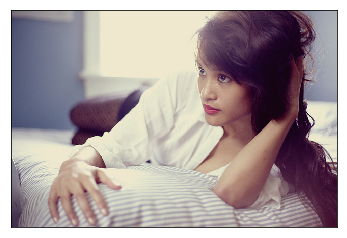

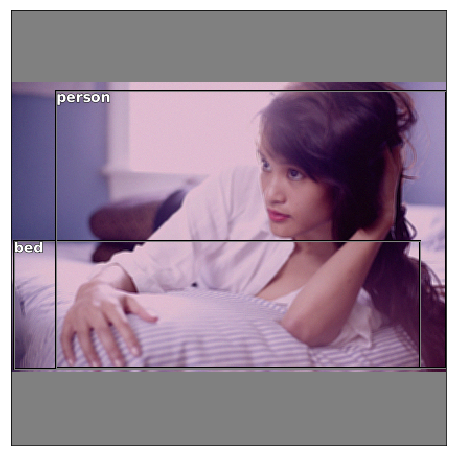

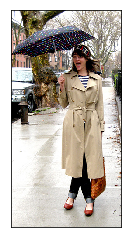

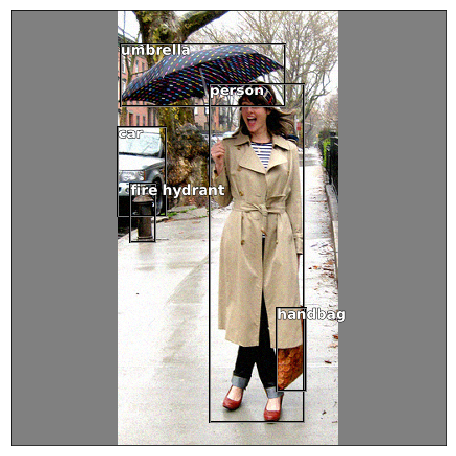

In [13]:
sz = 416
bs = 2
dim = (sz, sz)

bbs_idx=np.arange(1,5)

transform_train = getTransforms(dim, bbs_idx=bbs_idx, box_coord_scale='ratio', isTrain=True)
transform_eval = getTransforms(dim, bbs_idx=bbs_idx, box_coord_scale='ratio', isTrain=False)

train_ds = COCODataset(train_target_txt, dim=dim, bbs_idx=bbs_idx, transform=transform_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=variable_shape_collate_fn, num_workers=0)

#sample = train_ds[0]
sample = next(iter(train_dl))

for org_img, letterbox_img, transform, labels, img_path in zip(sample['org_img'], sample['img'], sample['transform'], sample['label'], sample['img_path']):
    show_img(org_img.permute(1,2,0))
    test_show_output(letterbox_img.permute(1,2,0), labels, False)